In [1]:
import networkx as nx
import numpy as np
import torch
from model import CaT
from CaT.datasets import reorder_dag, get_full_ordering
from utils.inference import CausalInference
import matplotlib.pyplot as plt
from datasets import get_full_ordering, reorder_dag

shuffling = 0
seed = 1
standardize = 0
sample_size = 100000
batch_size = 100
max_iters = 20000
eval_interval = 100
eval_iters = 100
validation_fraction = 0.3
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cuda'
dropout_rate = 0.0
learning_rate = 5e-3
ff_n_embed = 30
num_heads = 2
n_layers = 2
embed_dim = 30
head_size = 30


We create data from a 'true' DAG (which is DAGnx3 below) but also provide two other DAGs which are incorrect in different ways. DAGnx1 is fully exogenous, and DAGnx2 has one missing edge and another directed edge reversed.

We imagine we are interested in the 'total' effect of X -> Y.  As these simulations are linear, this effect can be calculated easily by hand.

In the case where X1 -> Y and X1 -> X2 -> Y, the total effect is the sum of the effect from both paths. e.g. if X1 -> Y has a coefficient of  0.8,  X1 -> X2 of 0.8, and X2 -> Y of 0.4, then the total effect is 0.8 + (0.8 x 0.4) = 1.12

In [2]:
def generate_data(N, d=1):
    DAGnx1 = nx.DiGraph()
    DAGnx2 = nx.DiGraph()
    DAGnx3 = nx.DiGraph()  # correct graph
    
    Ux1 = np.random.randn(N,d)
    X1 =  Ux1

    Ux2 = np.random.randn(N,d)
    X2 =  0.8 * X1 + Ux2
    
    X20 = Ux2
    X21 = 0.8 + Ux2

    Uy = np.random.randn(N,d)
    Y =  0.8 * X1 + 0.4 * X2 + Uy  # 0.4*0.8   + 0.8 = 1.12  Total effect
    
    Ux3 = np.random.randn(N,d)
    X3 = 0.7 * Y + 0.6 * X1 + Ux3

    Y0 = 0.4 * X20 + Uy 
    Y1 = 0.8 + 0.4 * X21 + Uy

    all_data_dict = {'X1': X1, 'X2': X2, 'X3': X3, 'Y': Y}

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X1': 'cont', 'X2': 'cont', 'X3': 'cont', 'Y': 'cont'}

    DAGnx1.add_edges_from([('X1', 'Y'), ('X2', 'Y'), ('X3', 'Y')])
    DAGnx1 = reorder_dag(dag=DAGnx1)  # topologically sorted dag
    var_names1 = list(DAGnx1.nodes())  # topologically ordered list of variables
    all_data1 = np.stack([all_data_dict[key] for key in var_names1], axis=1)
    causal_ordering1 = get_full_ordering(DAGnx1)
    ex_dag_stuff = (all_data1, DAGnx1, var_names1, causal_ordering1, var_types)
    
    DAGnx2.add_edges_from([('X1', 'Y'), ('X1', 'X2'), ('X2', 'Y'), ('X3', 'Y')])
    DAGnx2 = reorder_dag(dag=DAGnx2)  # topologically sorted dag
    var_names2 = list(DAGnx2.nodes())  # topologically ordered list of variables
    all_data2 = np.stack([all_data_dict[key] for key in var_names2], axis=1)
    causal_ordering2 = get_full_ordering(DAGnx2)
    mediated_dag_stuff = (all_data2, DAGnx2, var_names2, causal_ordering2, var_types)
    
    DAGnx3.add_edges_from([('X1', 'Y'), ('X1', 'X2'), ('X1', 'X3'), ('X2', 'Y'), ('Y', 'X3')])
    DAGnx3 = reorder_dag(dag=DAGnx3)  # topologically sorted dag
    var_names3 = list(DAGnx3.nodes())  # topologically ordered list of variables
    all_data3 = np.stack([all_data_dict[key] for key in var_names3], axis=1)
    causal_ordering3 = get_full_ordering(DAGnx3)
    correct_dag_stuff =  (all_data3, DAGnx3, var_names3, causal_ordering3, var_types)

    return ex_dag_stuff, mediated_dag_stuff, correct_dag_stuff, Y0, Y1

d=1
_, _, _, Y0, Y1 = generate_data(N=1000000, d=d)
ATE = (Y1 - Y0).mean(0)  
ex_dag_stuff, mediated_dag_stuff, correct_dag_stuff, Y0, Y1 = generate_data(N=sample_size, d=d)

all_data1, DAGnx1, var_names1, causal_ordering1, var_types1 = ex_dag_stuff
all_data2, DAGnx2, var_names2, causal_ordering2, var_types2 = mediated_dag_stuff
all_data3, DAGnx3, var_names3, causal_ordering3, var_types3 = correct_dag_stuff

print(var_names1, 'ATE of X1 on Y:', ATE)
print(all_data1.shape)

['X1', 'X2', 'X3', 'Y'] ATE of X1 on Y: [1.12]
(100000, 4, 1)


Incorrect DAG 1:


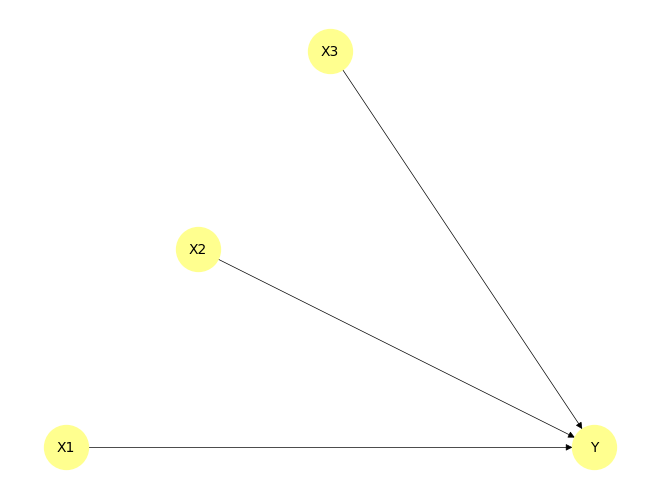

Incorrect DAG 2:


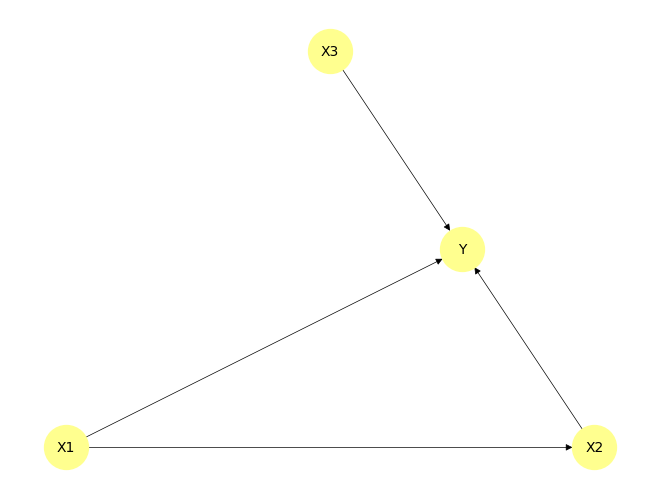

Correct DAG:


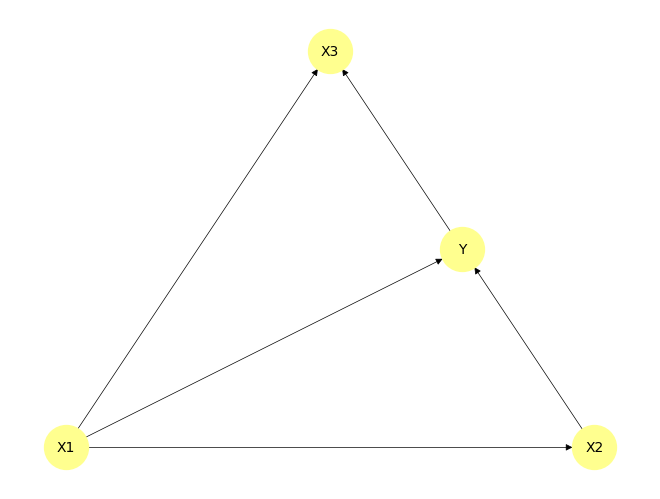

In [3]:
print('Incorrect DAG 1:')
nx.draw_planar(
    DAGnx1,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.5,
    font_size=10,
)
plt.show()

print('Incorrect DAG 2:')
nx.draw_planar(
    DAGnx2,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.5,
    font_size=10,
)
plt.show()

print('Correct DAG:')
nx.draw_planar(
    DAGnx3,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.5,
    font_size=10,
)
plt.show()

We run the model with the same data each time (although the column ordering of the data is different in each case, according to the assumed underlying DAG), and provide fit statistics as well as estimated causal links.

### Incorrect DAG 1 (fully exogenous)

In [4]:
indices = np.arange(0, len(all_data1))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data1[train_inds]
val_data = all_data1[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

input_dim = all_data1.shape[2]

model1 = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    embed_dim= embed_dim,
                    dag=DAGnx1,
                    causal_ordering=causal_ordering1,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types1, activation_function='Swish'
                    ).to(device)

optimizer = torch.optim.AdamW(model1.parameters(), lr=learning_rate)

def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model1.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model1(X=xb, targets=xb_mod
                                )

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model1.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model1(X=xb, targets=xb_mod)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model1.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")
 

step 0 of 20000: train_loss 3.4367, val loss 3.5552
step 100 of 20000: train_loss 0.6900, val loss 0.6938
step 200 of 20000: train_loss 0.6825, val loss 0.6586
step 300 of 20000: train_loss 0.6647, val loss 0.6666
step 400 of 20000: train_loss 0.7025, val loss 0.7252
step 500 of 20000: train_loss 0.6961, val loss 0.7068
step 600 of 20000: train_loss 0.7143, val loss 0.7138
step 700 of 20000: train_loss 0.6729, val loss 0.6609
step 800 of 20000: train_loss 0.6658, val loss 0.6913
step 900 of 20000: train_loss 0.6702, val loss 0.6895
step 1000 of 20000: train_loss 0.6773, val loss 0.6946
step 1100 of 20000: train_loss 0.6691, val loss 0.6538
step 1200 of 20000: train_loss 0.6885, val loss 0.6975
step 1300 of 20000: train_loss 0.6547, val loss 0.6786
step 1400 of 20000: train_loss 0.6761, val loss 0.6891
step 1500 of 20000: train_loss 0.6579, val loss 0.6931
step 1600 of 20000: train_loss 0.6612, val loss 0.6784
step 1700 of 20000: train_loss 0.6618, val loss 0.6709
step 1800 of 20000: tr

/home/matthewvowels/GitHub/Causal_Transformer/utils/inference.py:18: UserWarning: No mask has been specified. If padding has been used, the absence of a mask may lead to incorrect results.
  warnings.warn(


ATE: [1.12] est ATE: [0.27077529] error: [0.84922471]
Mean Squared Error Across All Vars: tensor(1.7041)
Mean Squared Error Across Outcome: tensor(0.6653)


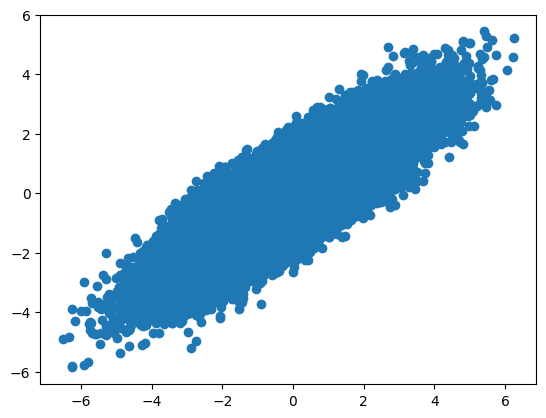

In [5]:
   
model1.eval()


int_nodes_vals0 = {'X1':np.array([0.0,])}
int_nodes_vals1 = {'X1':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names1.index(effect_var)

inf = CausalInference(dag=DAGnx1)
preds0 = inf.forward(all_data1, model=model1, intervention_nodes_vals=int_nodes_vals0)
preds1 = inf.forward(all_data1, model=model1, intervention_nodes_vals=int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model1(train_data.to(device))
plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())
print('Mean Squared Error Across All Vars:', ((train_data - preds.detach().cpu())**2).mean())
print('Mean Squared Error Across Outcome:', ((train_data[:,effect_index,:] - preds[:,effect_index,:].detach().cpu())**2).mean())

## Incorrect DAG 2 (missing and reverse edges)

In [6]:
indices = np.arange(0, len(all_data2))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data2[train_inds]
val_data = all_data2[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

input_dim = all_data2.shape[2]

model2 = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    embed_dim= embed_dim,
                    dag=DAGnx2,
                    causal_ordering=causal_ordering2,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types2, activation_function='Swish'
                    ).to(device)

optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)

def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model2.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model2(X=xb, targets=xb_mod)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model2.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model2(X=xb, targets=xb_mod)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model2.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")
 

step 0 of 20000: train_loss 8.4819, val loss 8.4404
step 100 of 20000: train_loss 1.6971, val loss 1.7047
step 200 of 20000: train_loss 1.7025, val loss 1.7093
step 300 of 20000: train_loss 1.6768, val loss 1.7105
step 400 of 20000: train_loss 1.6871, val loss 1.6687
step 500 of 20000: train_loss 1.6673, val loss 1.6861
step 600 of 20000: train_loss 1.6631, val loss 1.6875
step 700 of 20000: train_loss 1.6743, val loss 1.6678
step 800 of 20000: train_loss 1.6462, val loss 1.6647
step 900 of 20000: train_loss 1.7067, val loss 1.7050
step 1000 of 20000: train_loss 1.6843, val loss 1.6258
step 1100 of 20000: train_loss 1.6590, val loss 1.6578
step 1200 of 20000: train_loss 1.6760, val loss 1.6767
step 1300 of 20000: train_loss 1.6580, val loss 1.6705
step 1400 of 20000: train_loss 1.6821, val loss 1.7108
step 1500 of 20000: train_loss 1.7000, val loss 1.6792
step 1600 of 20000: train_loss 1.6661, val loss 1.6854
step 1700 of 20000: train_loss 1.6718, val loss 1.7006
step 1800 of 20000: tr

ATE: [1.12] est ATE: [0.48470021] error: [0.63529979]
Mean Squared Error Across All Vars: tensor(1.5491)
Mean Squared Error Across Outcome: tensor(0.6720)


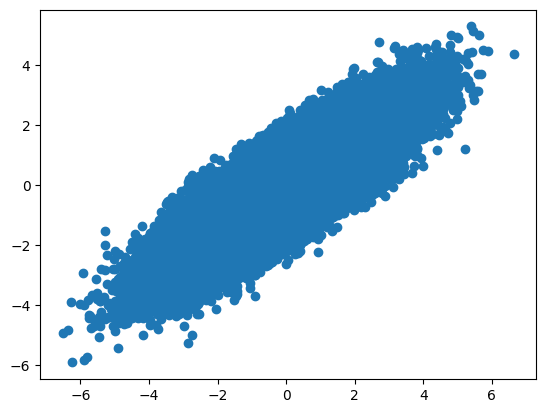

In [7]:
   
model2.eval()


int_nodes_vals0 = {'X1':np.array([0.0,])}
int_nodes_vals1 = {'X1':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names2.index(effect_var)

inf = CausalInference(dag=DAGnx2)
preds0 = inf.forward(all_data2, model=model2, intervention_nodes_vals=int_nodes_vals0)
preds1 = inf.forward(all_data2, model=model2, intervention_nodes_vals=int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model2(train_data.to(device))
plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())
print('Mean Squared Error Across All Vars:', ((train_data - preds.detach().cpu())**2).mean())
print('Mean Squared Error Across Outcome:', ((train_data[:,effect_index,:] - preds[:,effect_index,:].detach().cpu())**2).mean())

## Correct DAG

In [8]:
indices = np.arange(0, len(all_data3))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data3[train_inds]
val_data = all_data3[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

input_dim = all_data3.shape[2]

model3 = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    embed_dim= embed_dim,
                    dag=DAGnx3,
                    causal_ordering=causal_ordering3,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types3, activation_function='Swish'
                    ).to(device)

optimizer = torch.optim.AdamW(model3.parameters(), lr=learning_rate)

def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model3.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model3(X=xb, targets=xb_mod)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model3.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model3(X=xb, targets=xb_mod)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model3.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")
 

step 0 of 20000: train_loss 5.5690, val loss 5.5025
step 100 of 20000: train_loss 3.0368, val loss 2.9659
step 200 of 20000: train_loss 2.9939, val loss 3.0165
step 300 of 20000: train_loss 2.9999, val loss 2.9951
step 400 of 20000: train_loss 2.9939, val loss 2.9238
step 500 of 20000: train_loss 3.0671, val loss 3.0140
step 600 of 20000: train_loss 3.0295, val loss 3.0206
step 700 of 20000: train_loss 2.9638, val loss 3.0059
step 800 of 20000: train_loss 2.9903, val loss 2.9991
step 900 of 20000: train_loss 3.1656, val loss 3.0584
step 1000 of 20000: train_loss 3.0151, val loss 2.9791
step 1100 of 20000: train_loss 3.0465, val loss 2.9636
step 1200 of 20000: train_loss 3.0063, val loss 2.9292
step 1300 of 20000: train_loss 3.0021, val loss 2.9554
step 1400 of 20000: train_loss 3.0043, val loss 2.9968
step 1500 of 20000: train_loss 2.9842, val loss 2.9619
step 1600 of 20000: train_loss 3.0420, val loss 2.9448
step 1700 of 20000: train_loss 2.9997, val loss 3.0247
step 1800 of 20000: tr

ATE: [1.12] est ATE: [1.05465286] error: [0.06534714]
Mean Squared Error Across All Vars: tensor(1.0201)
Mean Squared Error Across Outcome: tensor(1.0037)


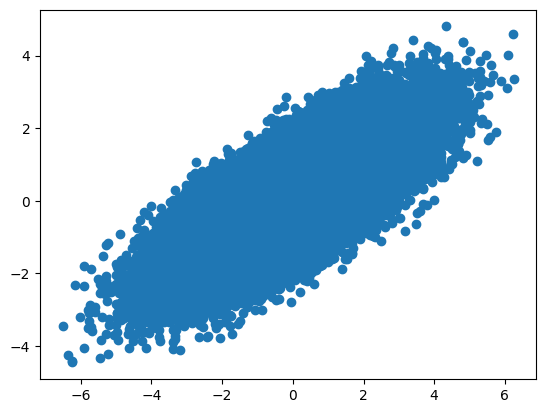

In [9]:
   
model3.eval()

int_nodes_vals0 = {'X1':np.array([0.0,])}
int_nodes_vals1 = {'X1':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names3.index(effect_var)

inf = CausalInference(dag=DAGnx3)
preds0 = inf.forward(all_data3, model=model3, intervention_nodes_vals=int_nodes_vals0)
preds1 = inf.forward(all_data3, model=model3, intervention_nodes_vals=int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model3(train_data.to(device))
plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())
print('Mean Squared Error Across All Vars:', ((train_data - preds.detach().cpu())**2).mean())
print('Mean Squared Error Across Outcome:', ((train_data[:,effect_index,:] - preds[:,effect_index,:].detach().cpu())**2).mean())